In [1]:
# stdlib
import collections
import importlib

# stack
import numpy as np
import pandas as pd
pd.set_option('display.width', 128)
pd.set_option('display.max_columns', 64)
pd.set_option('display.notebook_repr_html', True)

# inline matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import homework.bunch
import homework.plots

## Load Data

Load data from the CSV file.  The data is bundled into a class for convenience.

In [3]:
data_bunch = homework.bunch.RADARBunch('homework.csv')

## Data Exploration

Let us take a look at the source data summary statistics.

In [4]:
data_bunch.data_frame[data_bunch.source_columns].describe()

,CAN Global.Range_tg1,CAN Global.RelSpd_tg1,CAN Global.Angle_tg1,CAN Global.Status_tg1,CAN Global.LKTime_tg1
count,645.000000,645.000000,645.000000,645.0,645.000000
mean,40.996581,6.185912,-6.311108,1.0,193.039023
std,19.109802,3.853240,7.086380,0.0,12.415927
min,5.429853,-3.791982,-38.681824,1.0,0.000000
25%,23.573153,3.137203,-7.469543,1.0,184.800000
50%,46.249249,6.866624,-3.625916,1.0,193.330000
75%,60.031475,9.369266,-2.283691,1.0,201.810000
max,63.164837,21.536921,0.964813,1.0,210.300000


Let us also take a look at summary statistics for an object as an example.

In [5]:
data_bunch.get_subset_for_object(0).describe()

,aObject[0].Attributes.eClassification,aObject[0].Attributes.eDynamicProperty,aObject[0].General.uiLifeCycles,aObject[0].Kinematic.fDistX,aObject[0].Kinematic.fDistY,aObject[0].Kinematic.fVrelX,aObject[0].Kinematic.fVrelY
count,645.000000,645.0,645.000000,645.000000,645.000000,645.000000,645.000000
mean,0.392248,1.0,33.831008,66.673570,0.451114,-20.517773,-0.055846
std,1.400843,0.0,45.994980,43.876794,16.176451,0.231694,0.395550
min,0.000000,1.0,1.000000,-3.783875,-35.964081,-21.693348,-2.028023
25%,0.000000,1.0,3.000000,34.867611,-7.888619,-20.628386,-0.172558
50%,0.000000,1.0,13.000000,53.942055,-6.838051,-20.537344,-0.031160
75%,0.000000,1.0,41.000000,94.662094,19.527788,-20.402277,0.100783
max,6.000000,1.0,179.000000,191.036880,34.273628,-19.804201,1.381475


## Lifetime

It was advised that not all object data is useful.  Let us take a look at object life time to see which objects are real.

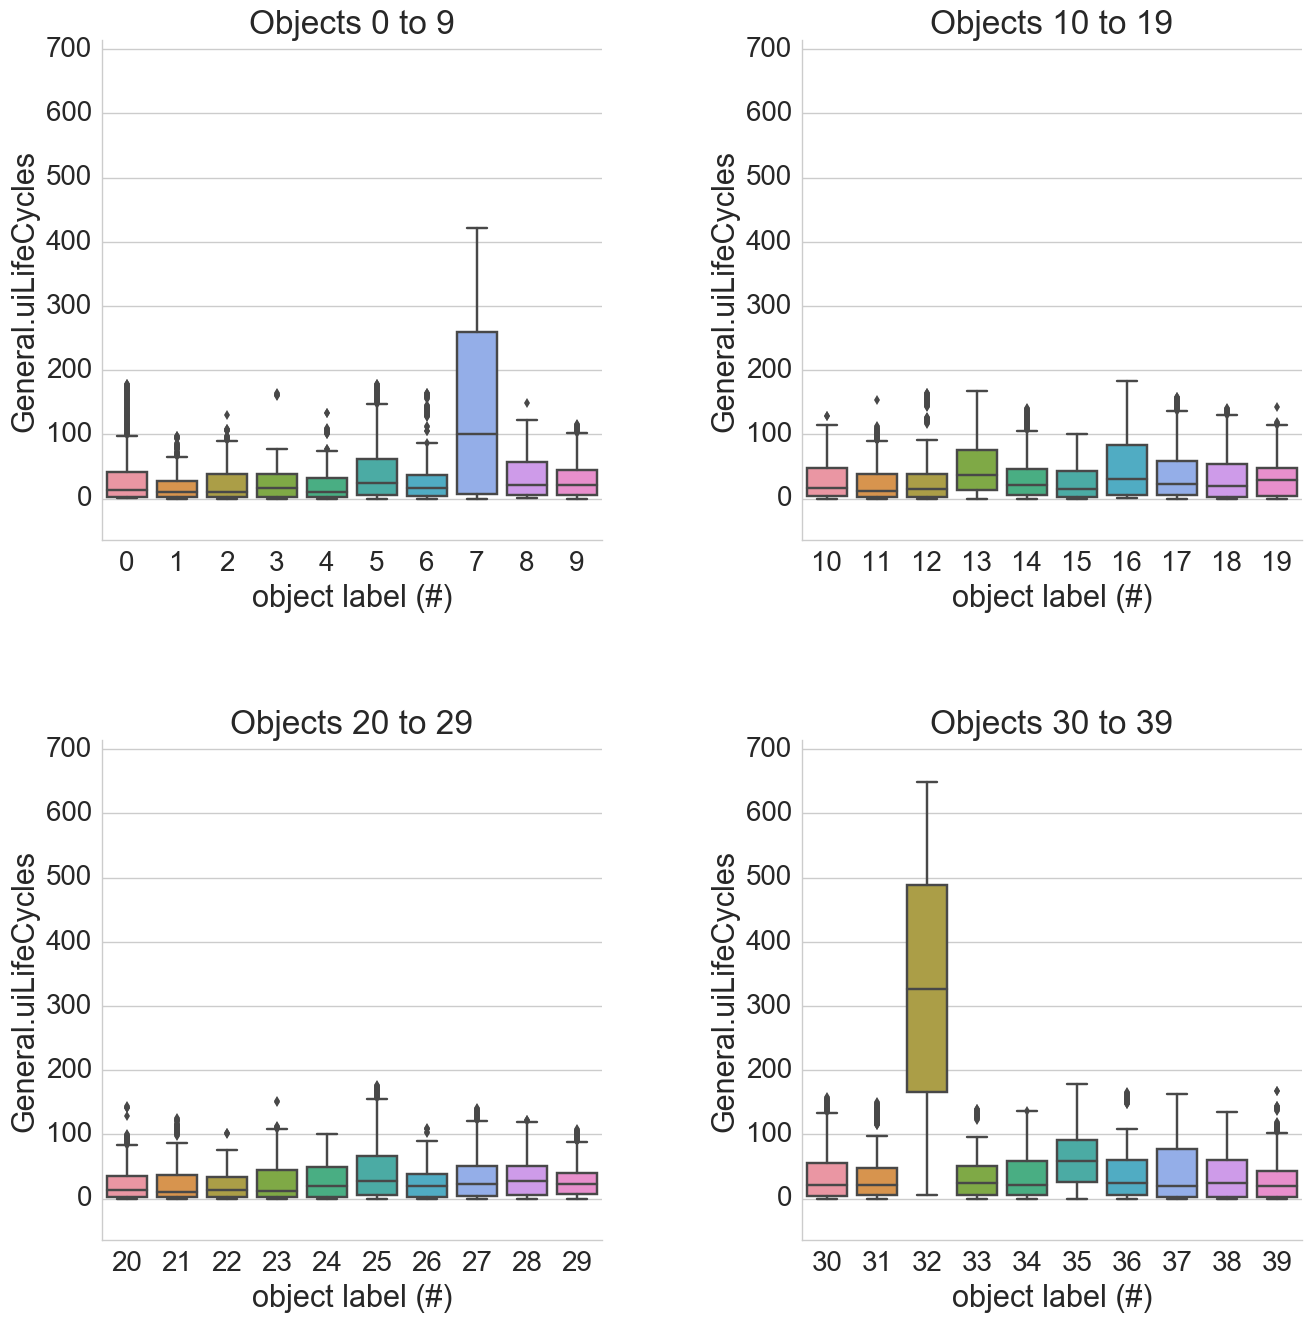

In [6]:
homework.plots.boxplot.many(data_bunch, trait='General.uiLifeCycles')

We can see that objects 7 and 32 stand out from the rest.  If we were to automate this process, one might consider the median lifetime above a certain threshold to identify the objects.

## Trajectory

Lets take a look at object 32.  Below we will plot the position (x, y) and velocity components (u, v) vs time.

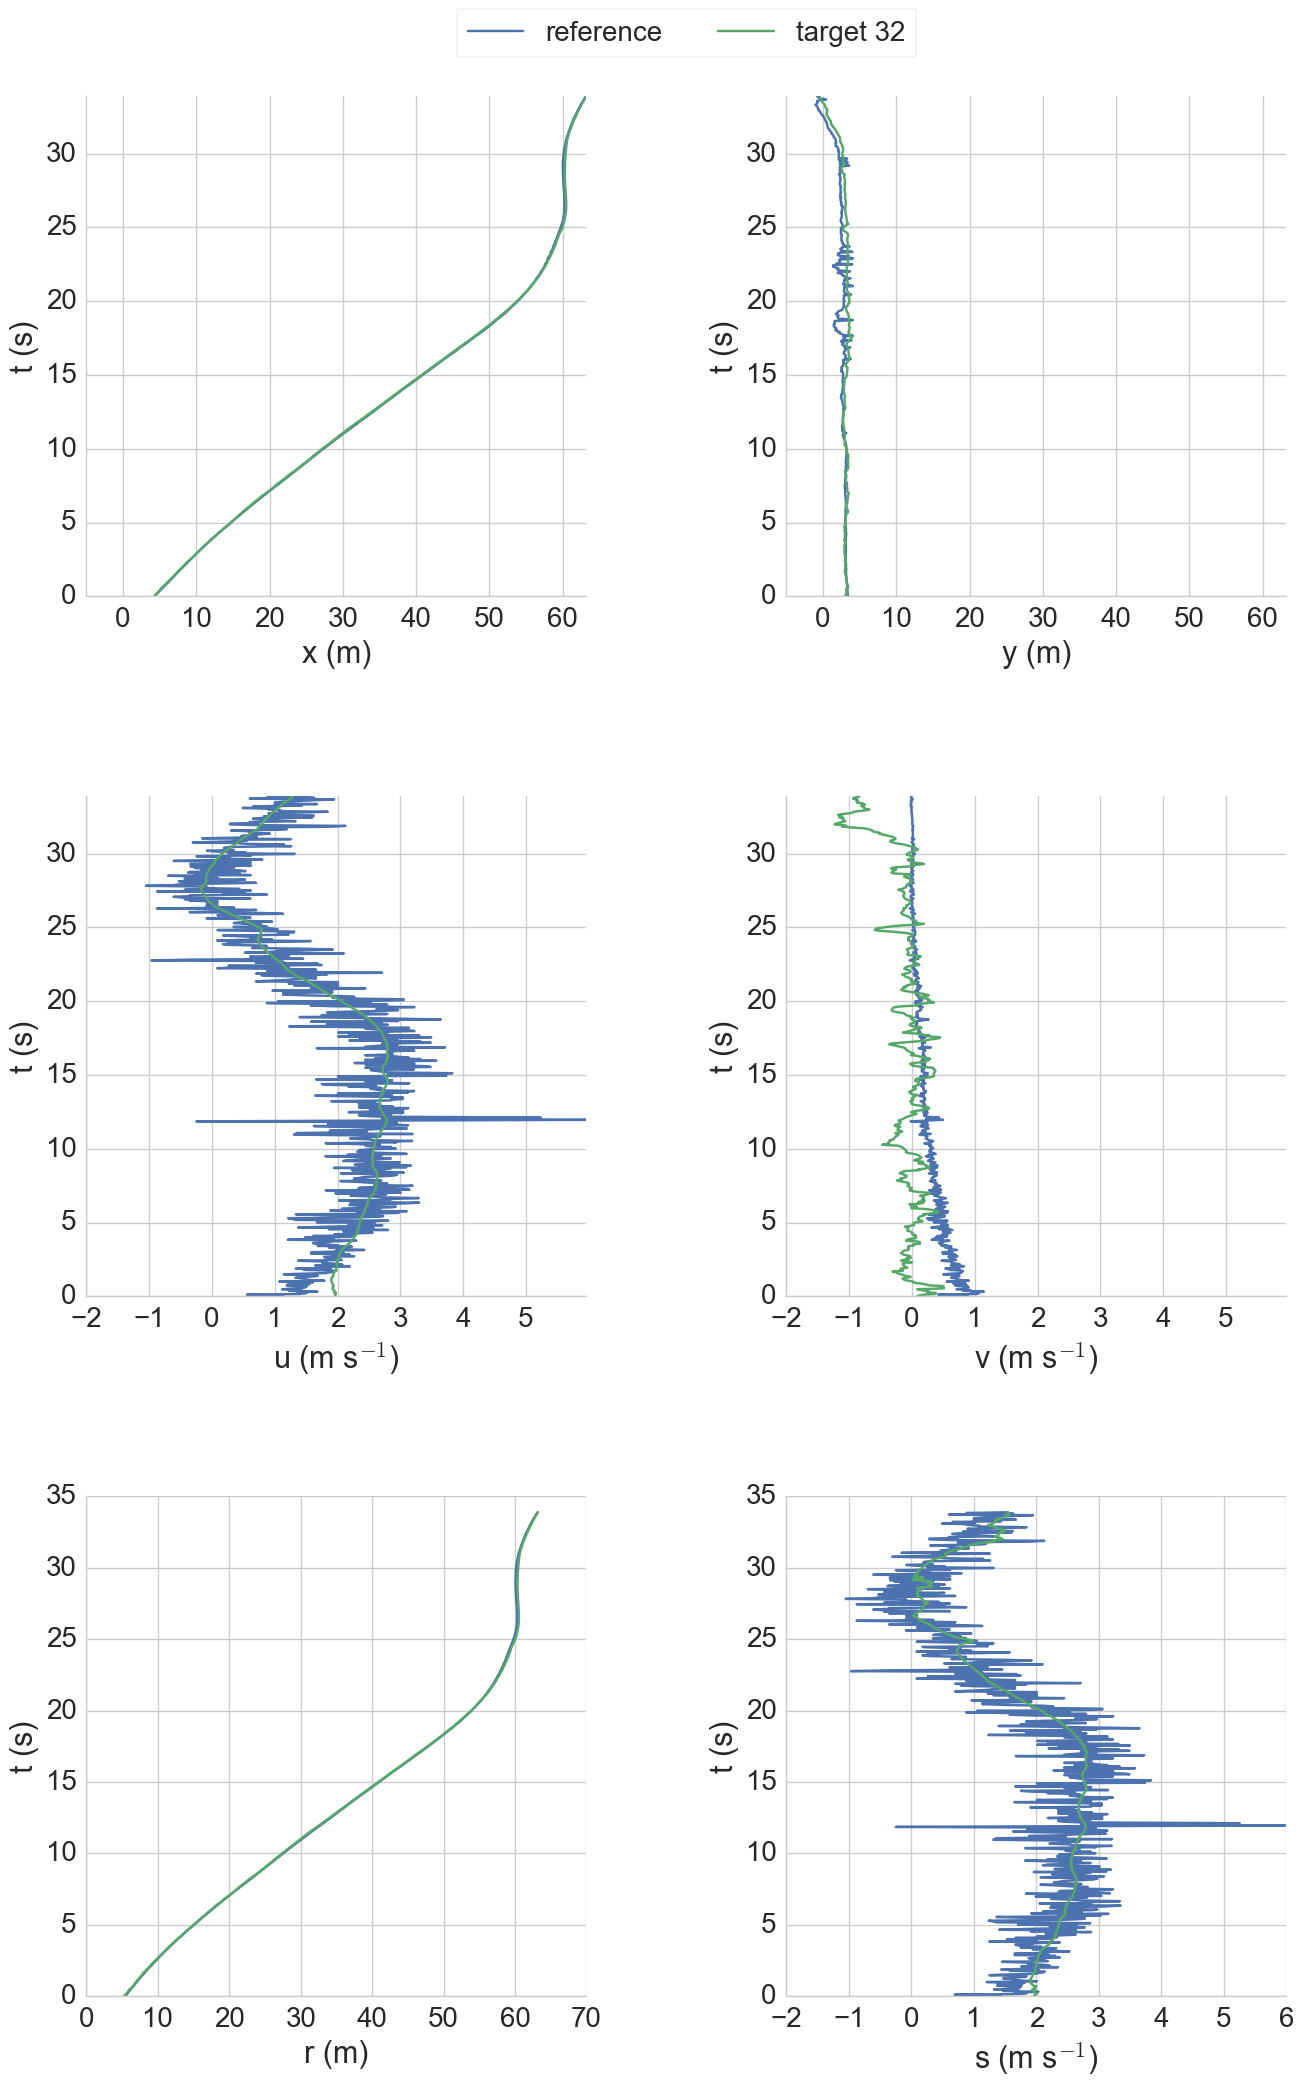

In [7]:
robj = homework.plots.trajectory.ReferenceObject(data_bunch)
tobj = homework.plots.trajectory.TargetObject(data_bunch, 32)
objs = [robj, tobj]

tlim = homework.plots.trajectory.determin_extent(objs, names=['t'])
qlim = homework.plots.trajectory.determin_extent(objs, names=['x', 'y'], v_min=-5)
plim = homework.plots.trajectory.determin_extent(objs, names=['u', 'v'], v_min=-2)

homework.plots.trajectory.components(objs, tlim=tlim, qlim=qlim, plim=plim)

The target appears to be moving in the positive x-direction, while remaining at a relatively constant y-distance.  The x-component of the velocity is sinusoidal, while the y-velocity is near zero.  The differential GPS velocity data is noisy.

## Reference-Target Difference

We can look at the difference between the reference and target position and velocity components.  Lets create a histogram to see if the "errors" are normally distributed.

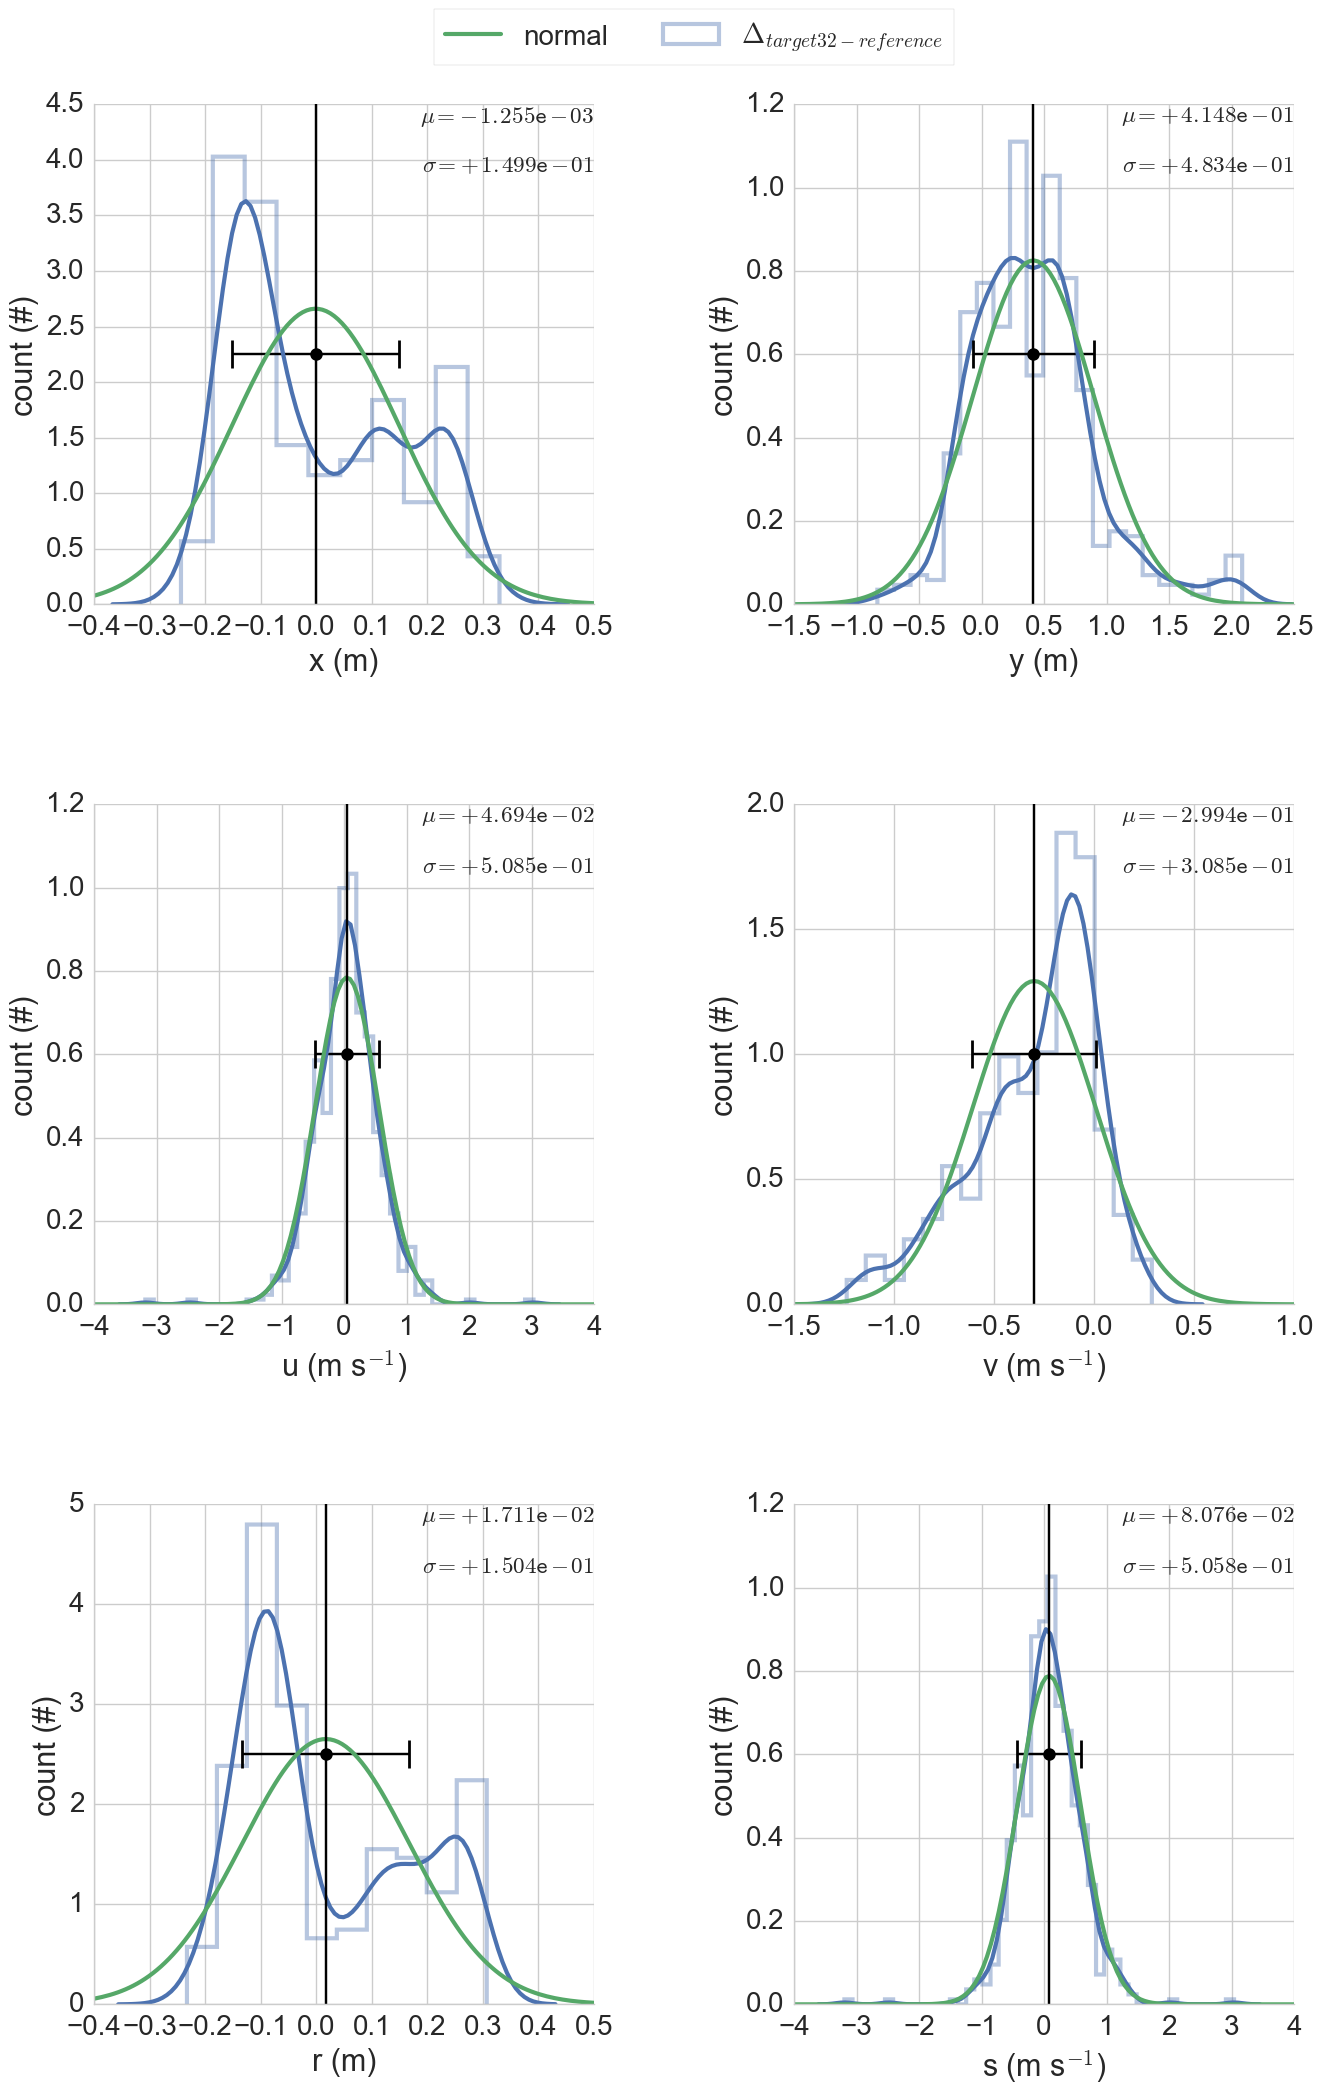

In [8]:
dobj = homework.plots.trajectory.DeltaObject(data_bunch, robj, tobj)
homework.plots.trajectory.components([dobj], func=homework.plots.trajectory.attr_histogram)

The (u) errors do appear to be normal.  The (x, y) and (v) errors are not normal.  We should be hesitant about taking the mean and standard deviation.  Lets do it anyway!

In [9]:
dobj_frame = dobj.to_data_frame()
dobj_frame.describe()

,t,x,y,r,u,v,s
count,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000
mean,16.925090,-0.001255,0.414813,0.017109,0.046944,-0.299352,0.080764
std,9.808772,0.150064,0.483754,0.150490,0.508923,0.308730,0.506190
min,0.000000,-0.243529,-0.833317,-0.232766,-3.179446,-1.236654,-3.194226
25%,8.438835,-0.132227,0.069634,-0.099730,-0.247309,-0.488947,-0.202057
50%,16.921416,-0.053737,0.350744,-0.051588,0.056462,-0.206600,0.074270
75%,25.397170,0.126367,0.658182,0.153357,0.341988,-0.071695,0.363670
max,33.887476,0.329814,2.084849,0.306848,3.031520,0.289000,3.039914


If we are to trust these values, it appears that the errors are on the order of a few cm or cm s$^{-1}$.

## Rolling Mean

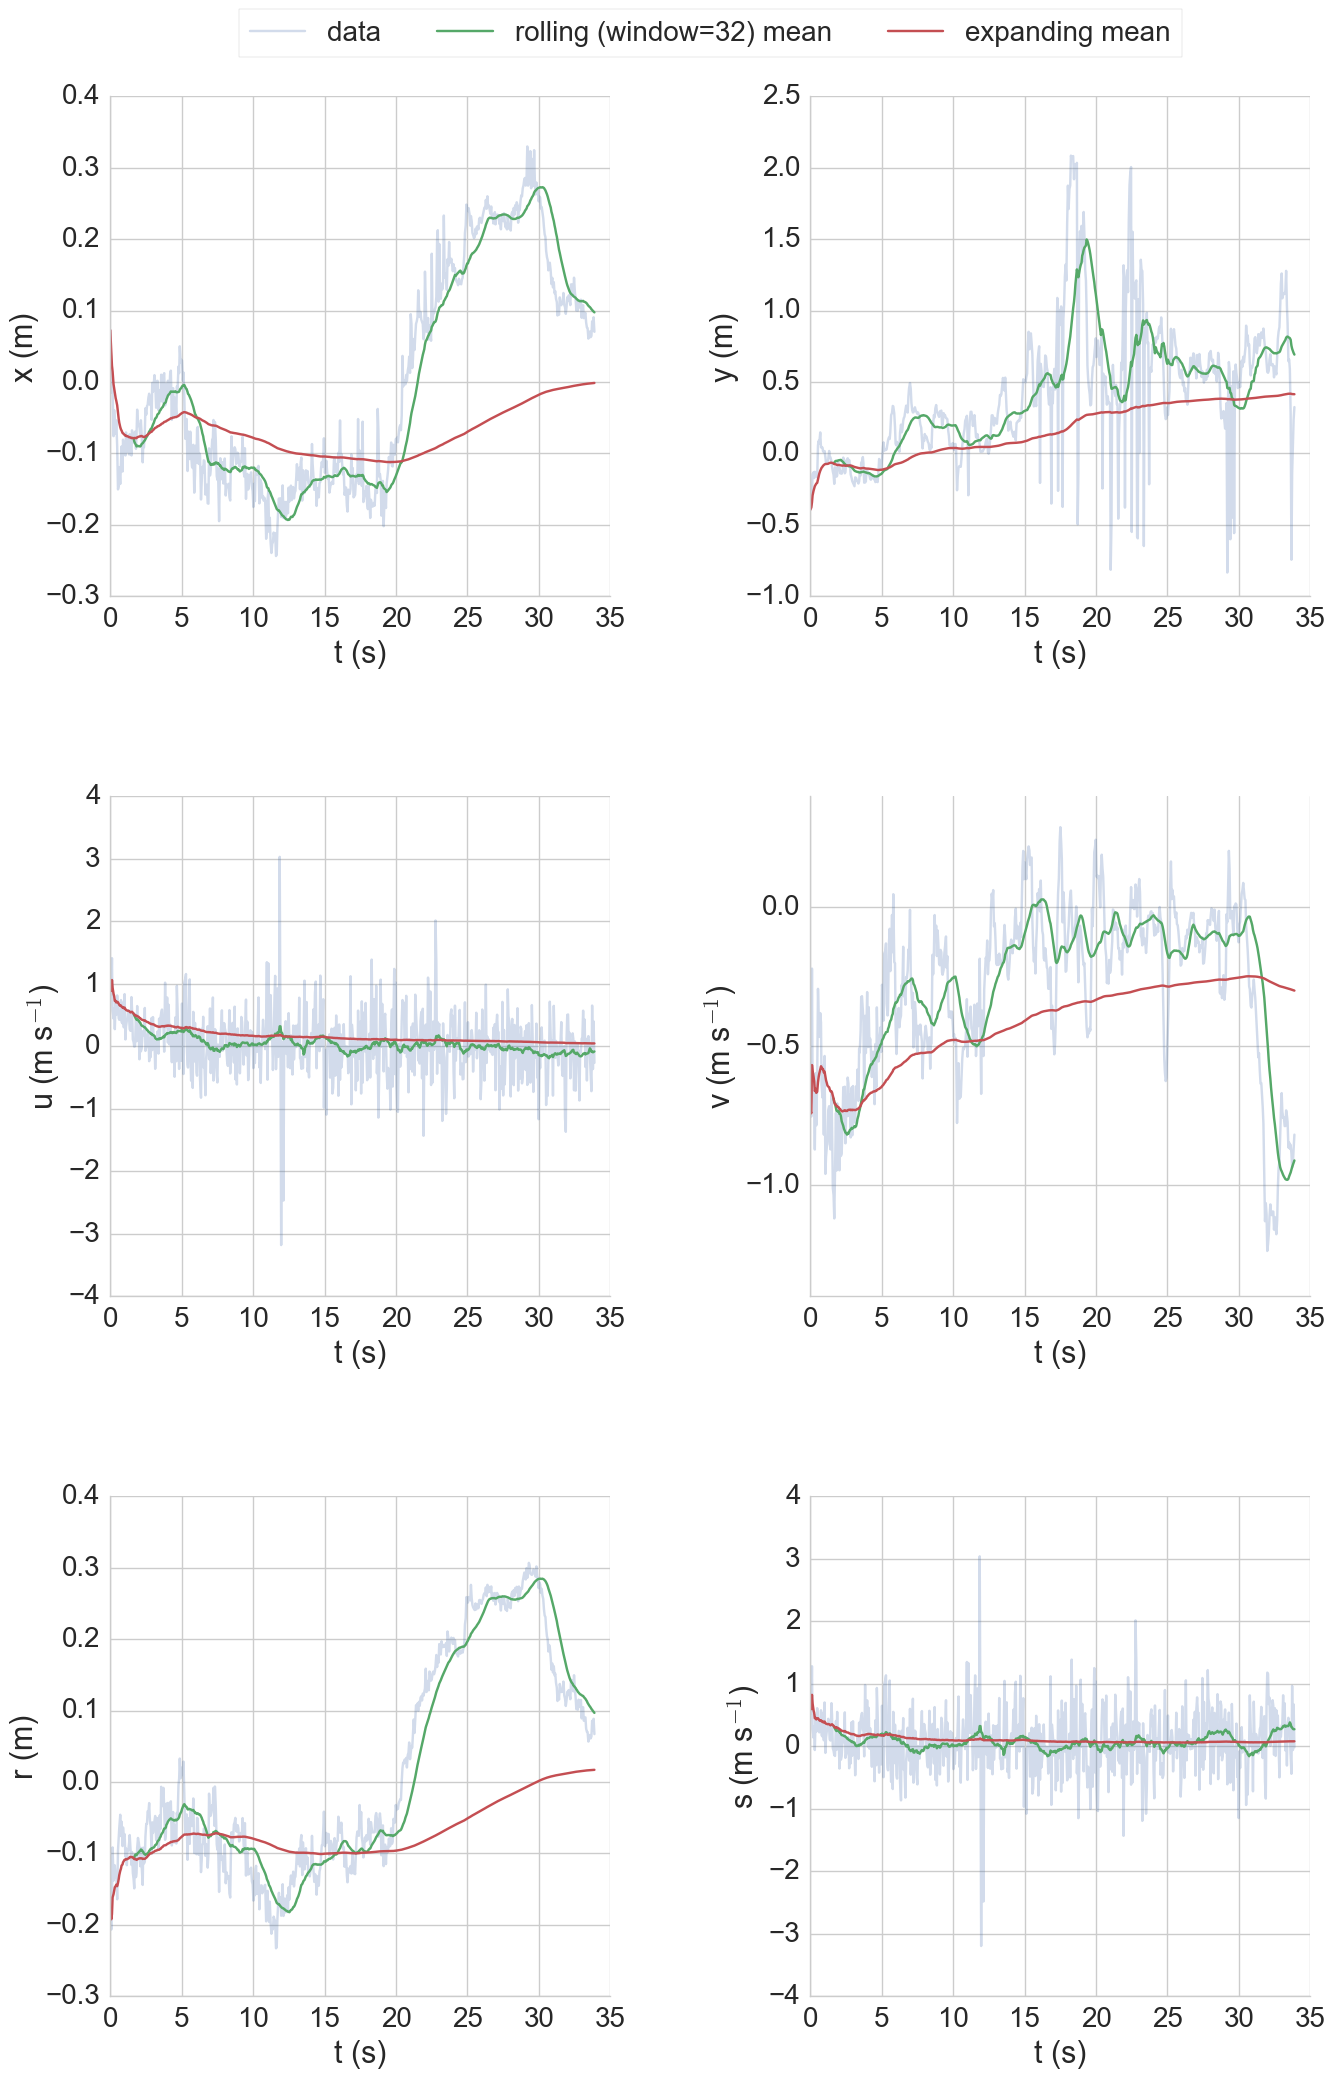

In [10]:
func = lambda *a, **k: homework.plots.trajectory.window(*a, func='mean', size=32, **k)
homework.plots.trajectory.components(objs=[dobj], func=func)

## Rolling Standard Deviation

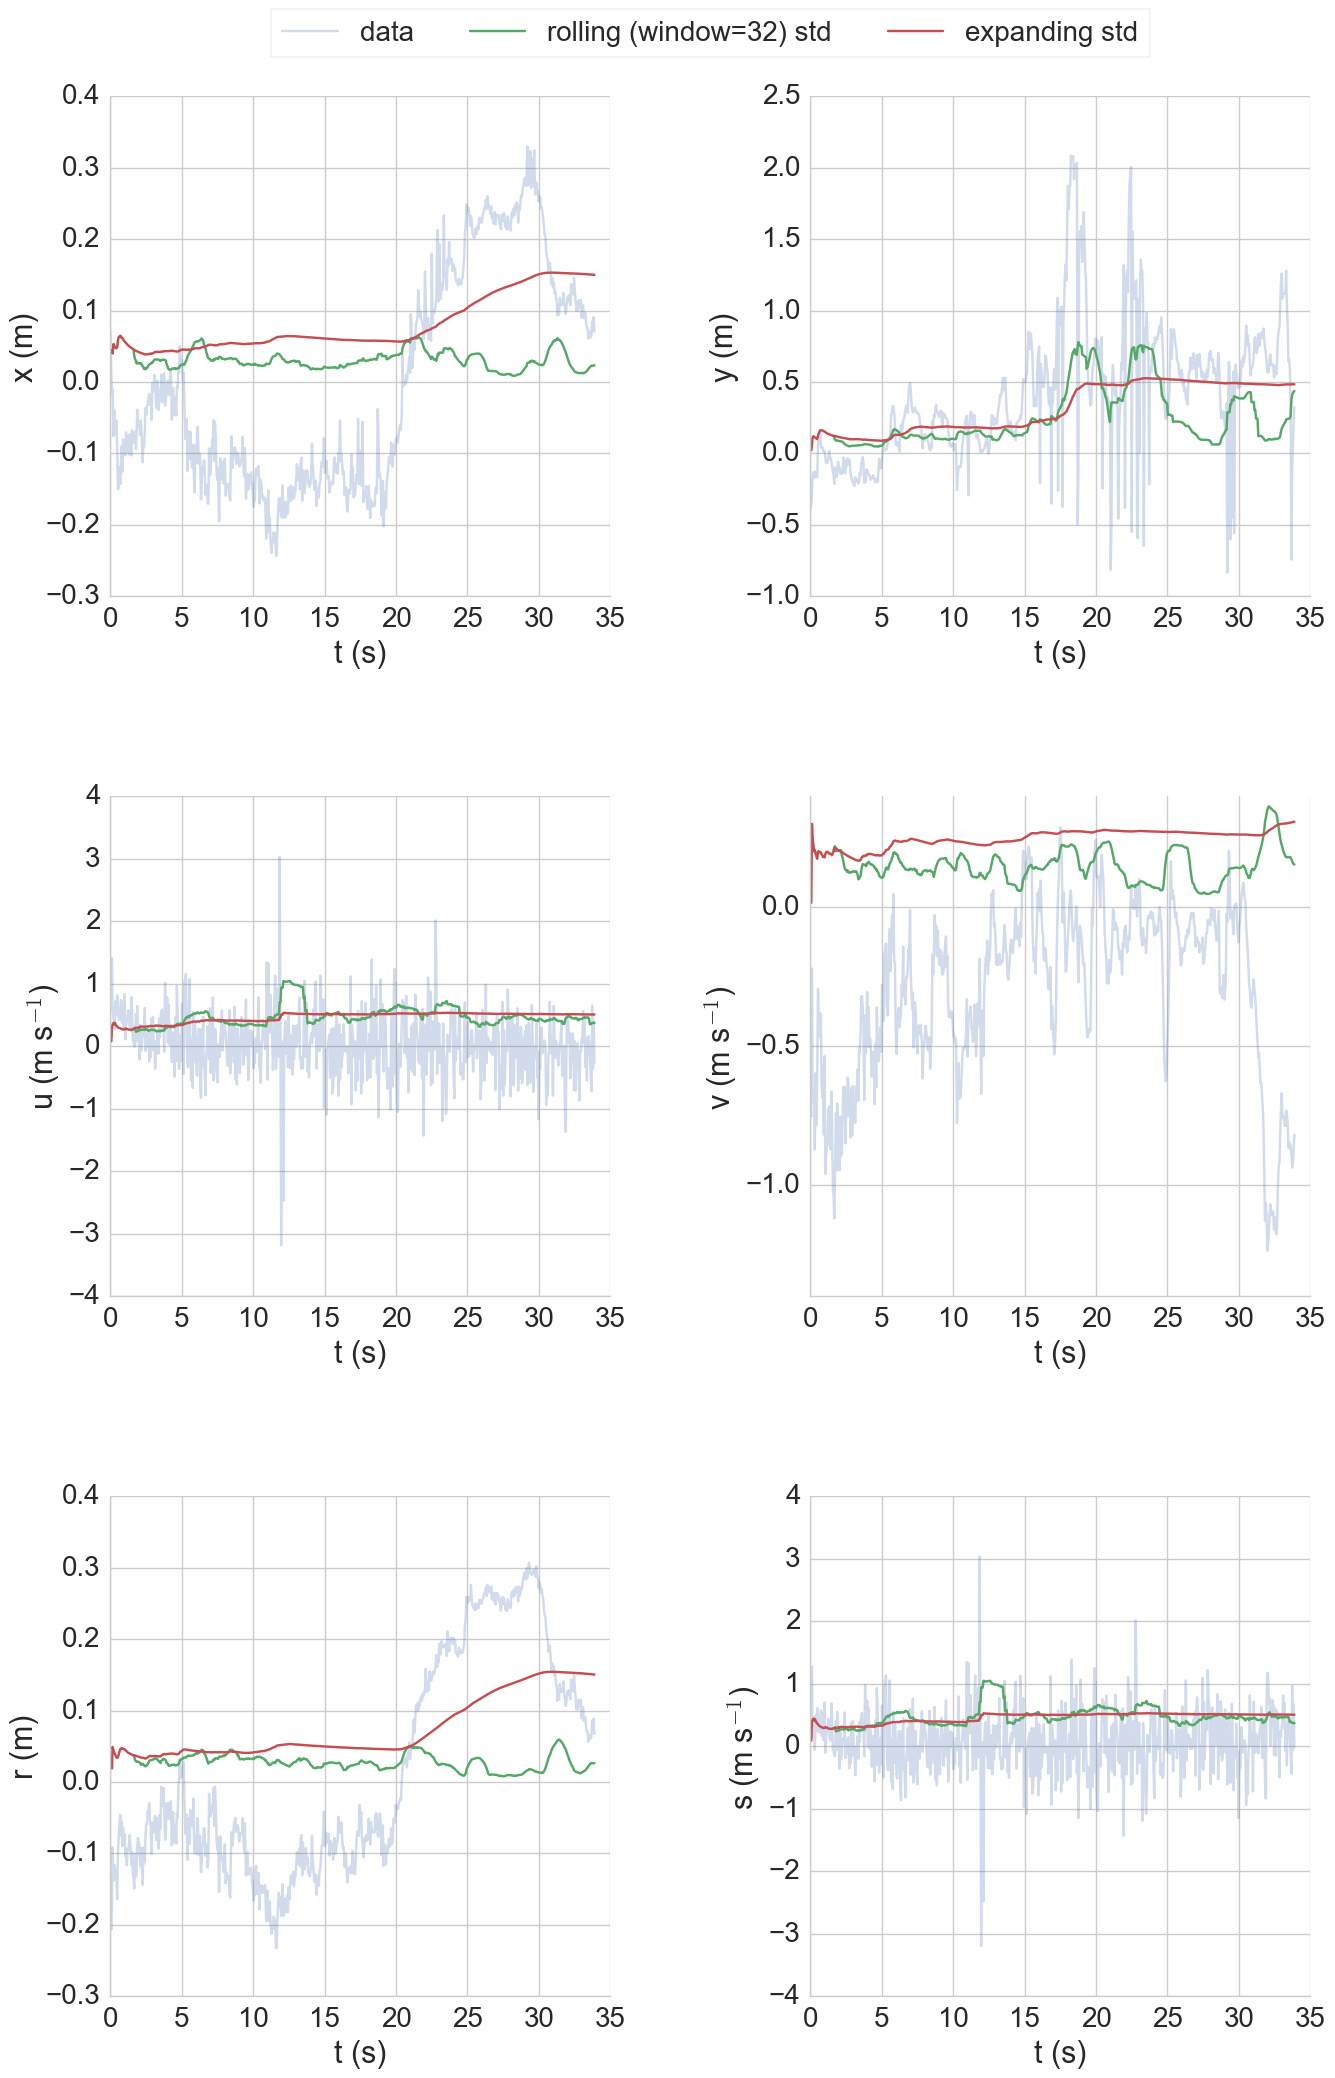

In [11]:
func = lambda *a, **k: homework.plots.trajectory.window(*a, func='std', size=32, **k)
homework.plots.trajectory.components(objs=[dobj], func=func)

## Rolling Median

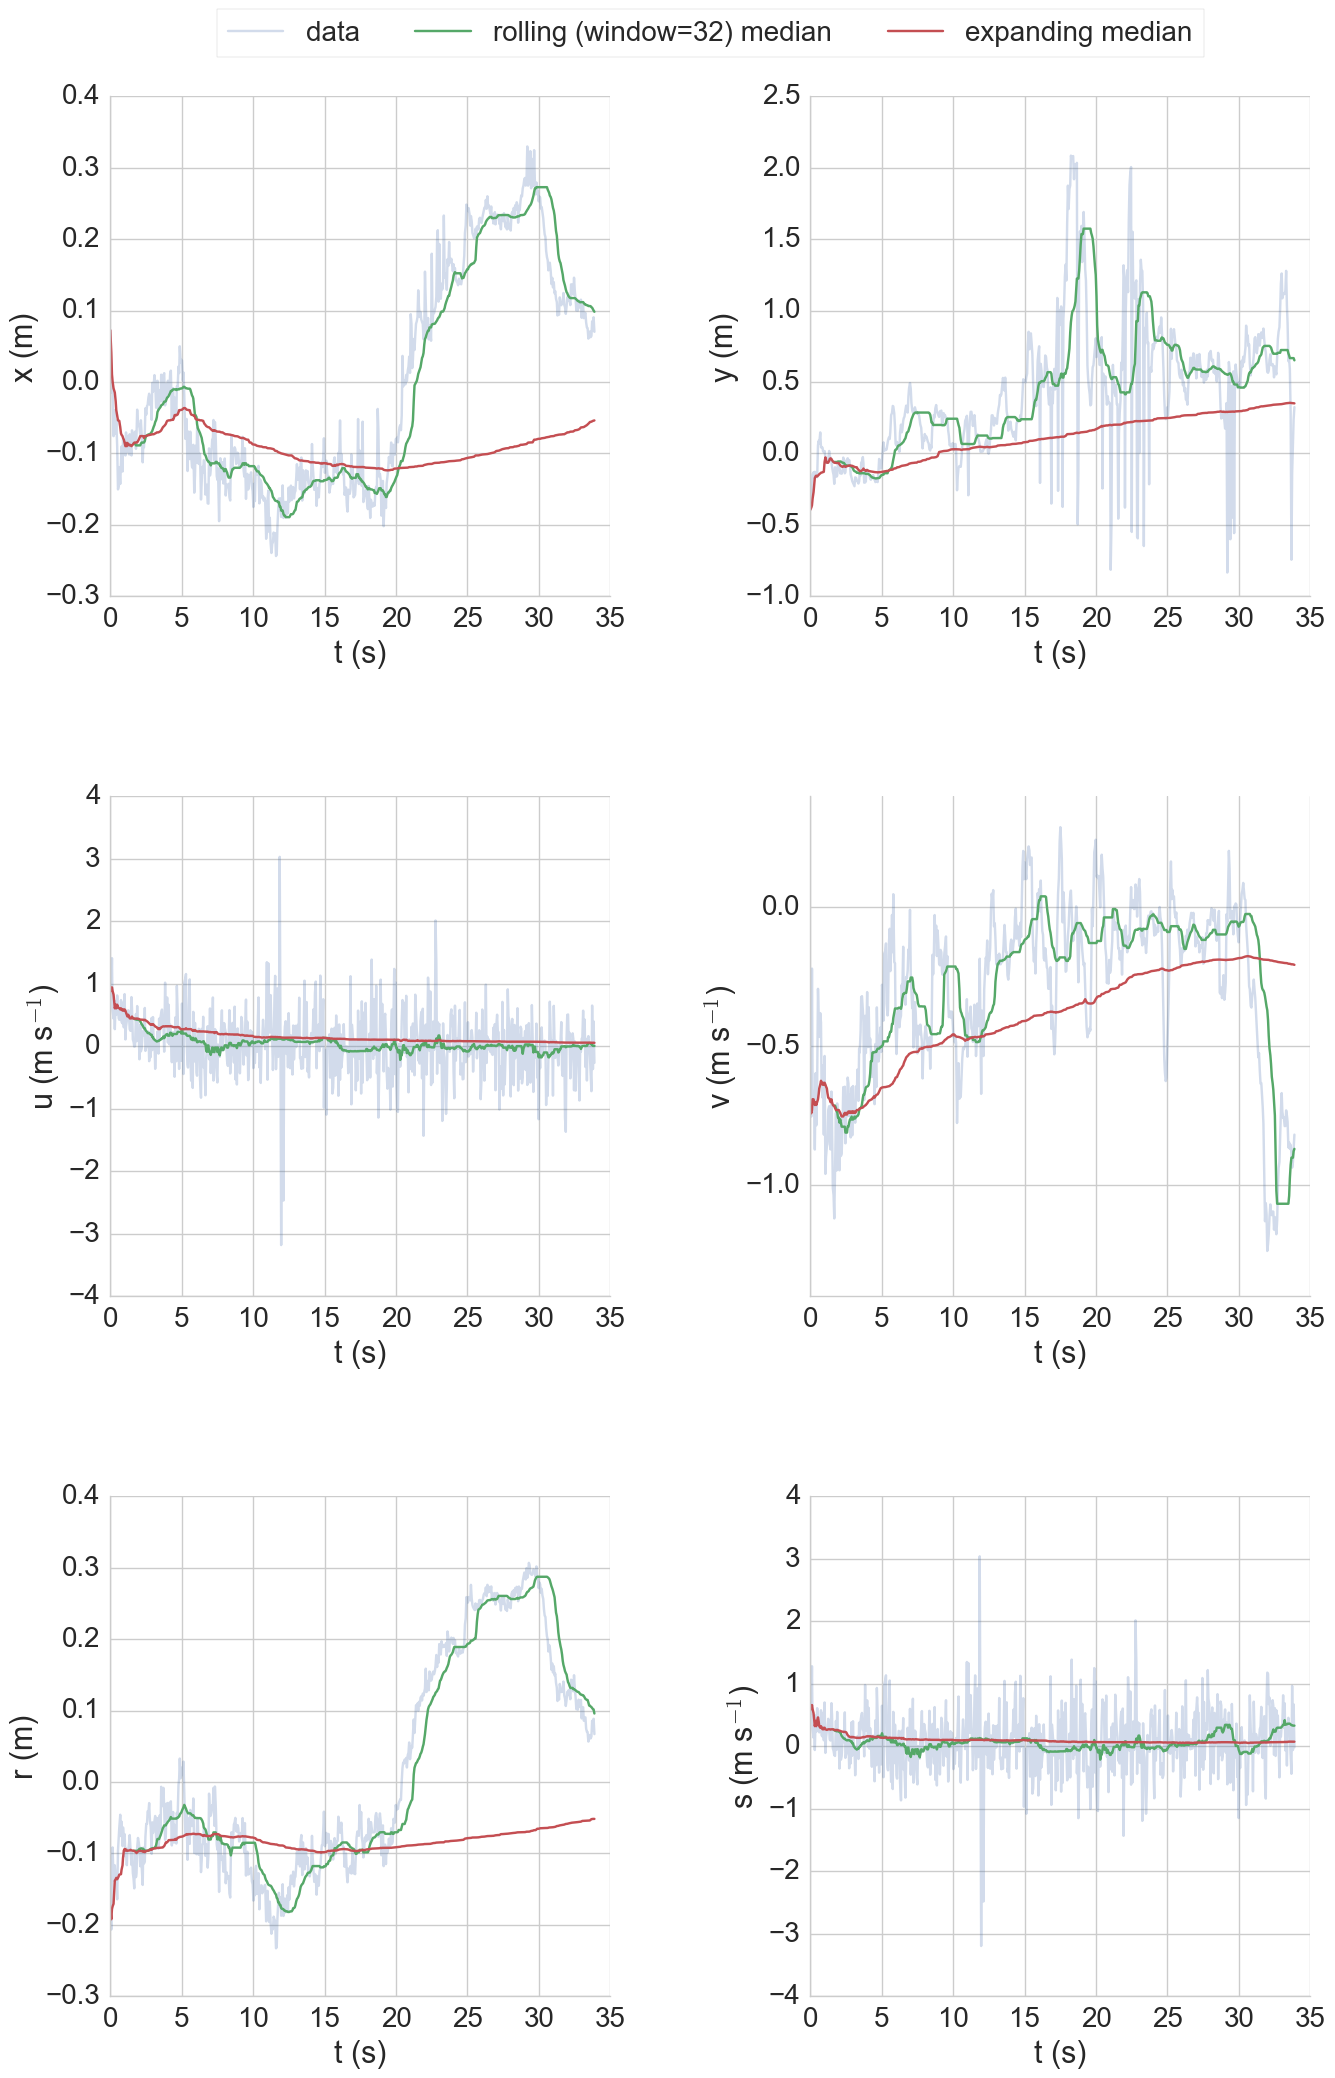

In [12]:
func = lambda *a, **k: homework.plots.trajectory.window(*a, func='median', size=32, **k)
homework.plots.trajectory.components(objs=[dobj], func=func)

## Rolling Covariance

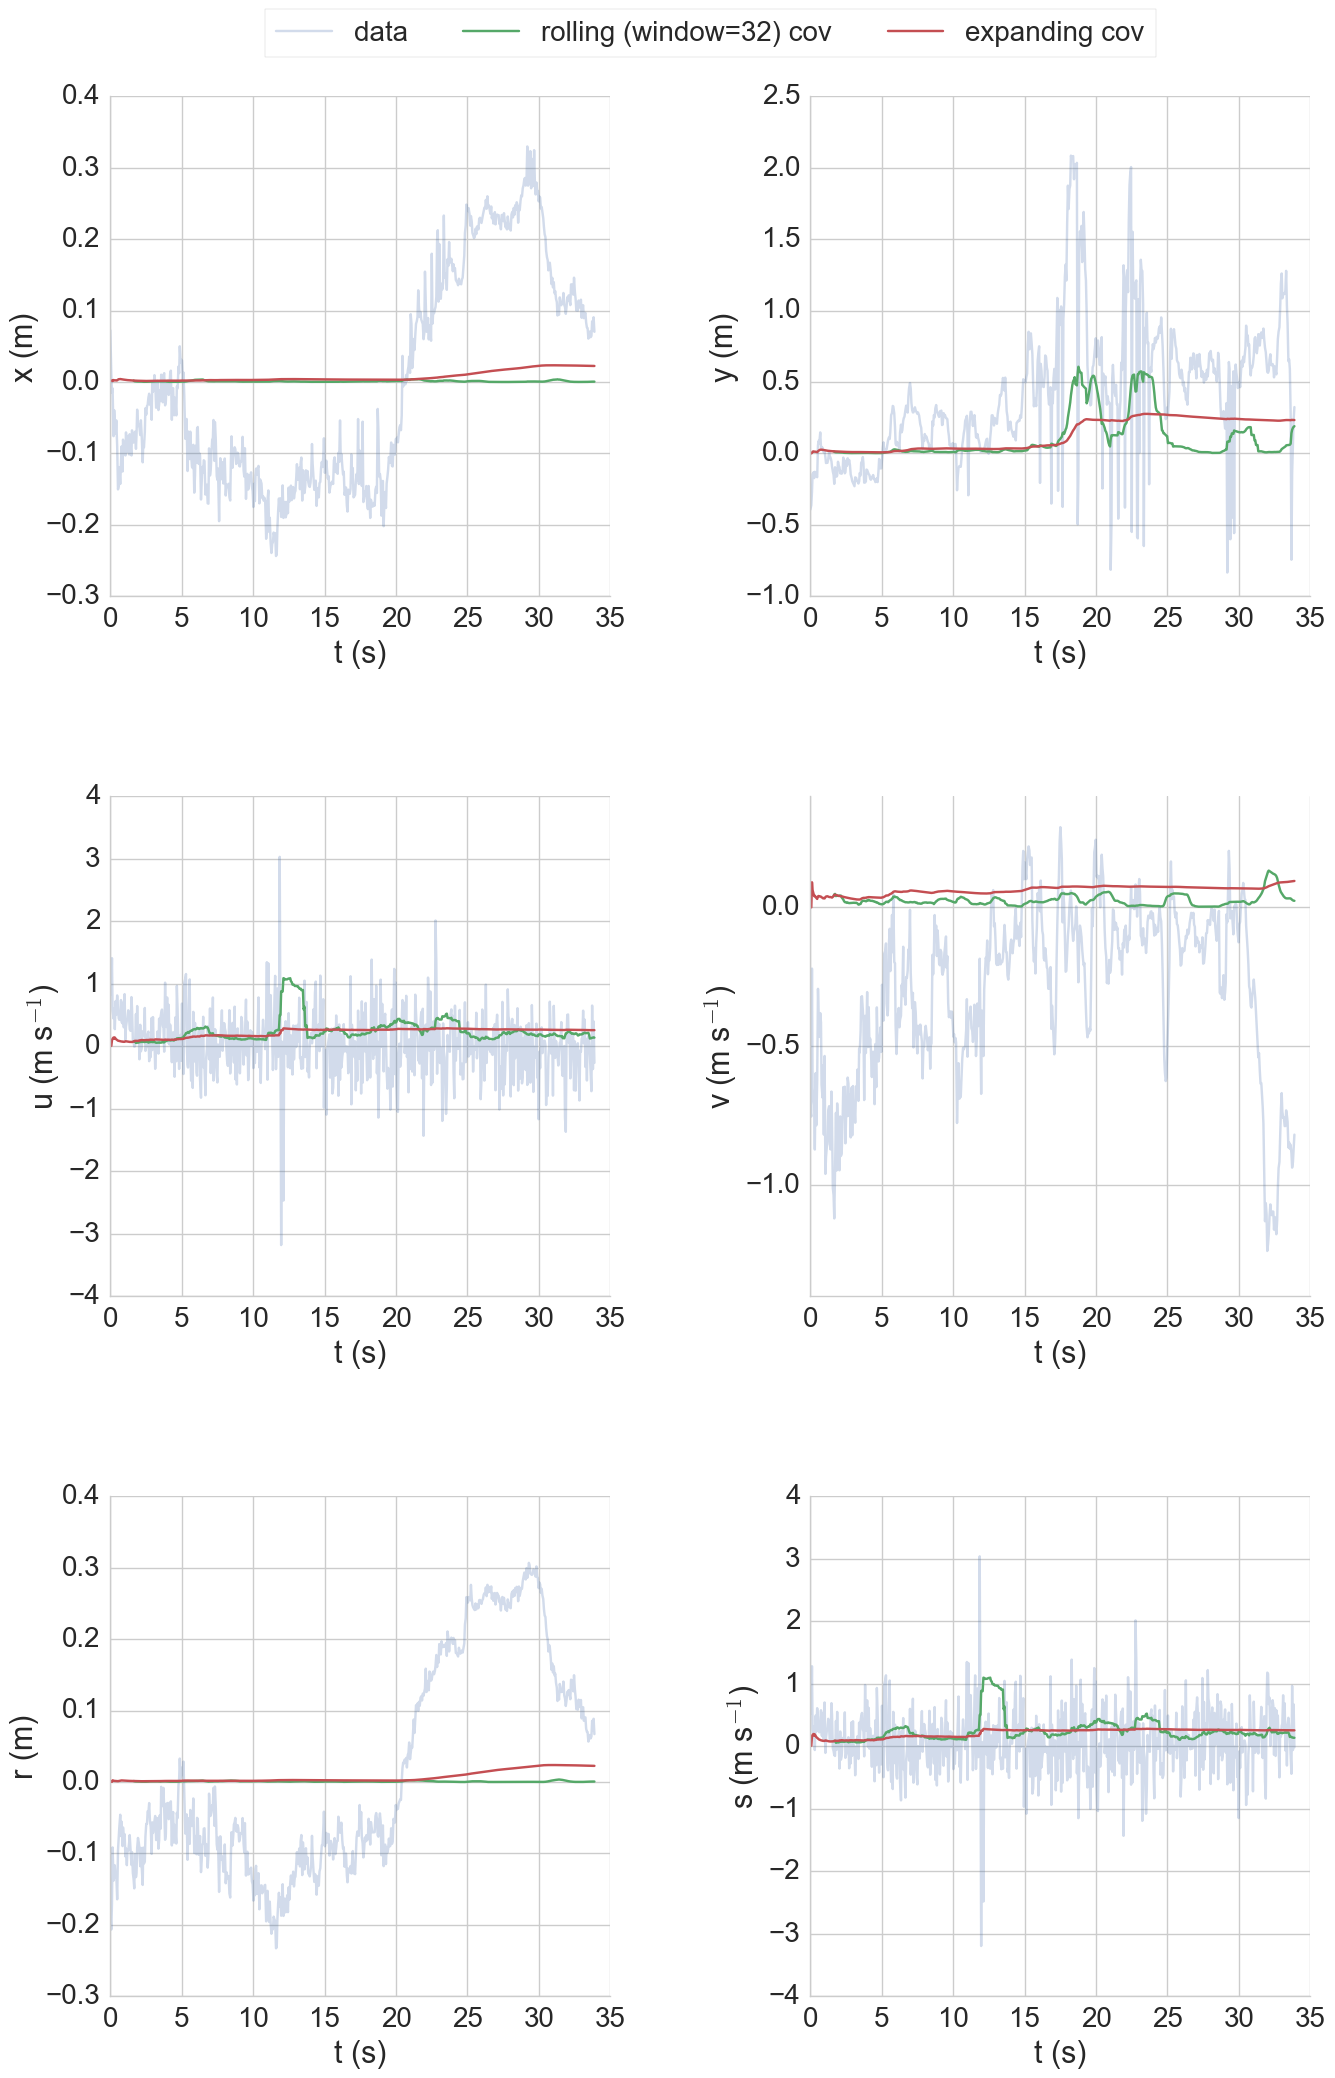

In [13]:
func = lambda *a, **k: homework.plots.trajectory.window(*a, func='cov', size=32, **k)
homework.plots.trajectory.components(objs=[dobj], func=func)